# Cat Image Classifier

This notebook implements a CNN to designed to detect cats in images



In [5]:
import tensorflow as tf
import os
import pathlib
import shutil
import matplotlib.pyplot as plt
import kagglehub

In [6]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Merge Data sets 
For the puposes of this project we will splice two datasets: karakaggle/kaggle-cat-vs-dog-dataset and mikhailma/house-rooms-streets-image-dataset into one specificed for cat detection.
This spliced dataset will contain cat image folder and a household image folder. The goal of our cnn will be to detect whether or not a cat is present in a household image.


In [ ]:
path_catVdog = kagglehub.dataset_download('karakaggle/kaggle-cat-vs-dog-dataset')
# Download the house-rooms-streets dataset
path_house = kagglehub.dataset_download('mikhailma/house-rooms-streets-image-dataset')


In [ ]:

# Create data directory if it doesn't exist
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Move cat images
cat_source = os.path.join(path_catVdog, "Cat")
cat_dest = os.path.join(data_dir, "Cat")
if os.path.exists(cat_source):
    if not os.path.exists(cat_dest):
        shutil.copytree(cat_source, cat_dest)
    print(f"Moved cat images to {cat_dest}")
else:
    print("Cat source directory not found")

# Move house images 
house_source = os.path.join(path_house, "house_data")
house_dest = os.path.join(data_dir, "house_data")
if os.path.exists(house_source):
    if not os.path.exists(house_dest):
        shutil.copytree(house_source, house_dest)
    print(f"Moved house images to {house_dest}")
else:
    print("House source directory not found")


In [24]:
class PetClassifier:
    def __init__(self, data_dir='dataset', img_size=160, batch_size=32):  # Reduced image size
        self.data_dir = pathlib.Path(data_dir)
        self.img_size = img_size
        self.batch_size = batch_size
        self.setup_hardware()

    def setup_hardware(self):
        """Configure TensorFlow for available hardware."""
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                tf.keras.mixed_precision.set_global_policy('mixed_float16')
                print(f"Training on {len(gpus)} GPU(s) with mixed precision")
            except RuntimeError as e:
                print(f"GPU setup error: {e}")
                print("Training on CPU")
        else:
            print("No GPU found. Training on CPU")
            
    def validate_and_copy_images(self, source_dir, dest_dir):
        """Validate images and copy only valid ones."""
        valid_count = 0
        invalid_count = 0
        
        os.makedirs(dest_dir, exist_ok=True)
        
        for img_name in os.listdir(source_dir):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
                
            source_path = os.path.join(source_dir, img_name)
            try:
                # Try to open and verify the image
                img = tf.io.read_file(source_path)
                img = tf.image.decode_image(img, channels=3)
                
                # If we got here, the image is valid
                dest_path = os.path.join(dest_dir, img_name)
                shutil.copy2(source_path, dest_path)
                valid_count += 1
                
            except Exception as e:
                print(f"Skipping corrupted image {img_name}: {str(e)}")
                invalid_count += 1
                
        return valid_count, invalid_count

    def prepare_dataset(self):
        """Create TensorFlow dataset with augmentation."""
        try:
            print("Checking data directory structure...")
            cat_dir = os.path.join(self.data_dir, 'Cat')
            house_dir = os.path.join(self.data_dir, 'house_data')
            
            # Create new directory structure
            processed_dir = os.path.join(self.data_dir, 'processed')
            positive_dir = os.path.join(processed_dir, 'cat')
            negative_dir = os.path.join(processed_dir, 'no_cat')
            
            # Clear processed directory if it exists
            if os.path.exists(processed_dir):
                shutil.rmtree(processed_dir)
            
            # Validate and copy images
            print("Validating and copying cat images...")
            cat_valid, cat_invalid = self.validate_and_copy_images(cat_dir, positive_dir)
            print(f"Cat images - Valid: {cat_valid}, Invalid: {cat_invalid}")
            
            print("Validating and copying house images...")
            house_valid, house_invalid = self.validate_and_copy_images(house_dir, negative_dir)
            print(f"House images - Valid: {house_valid}, Invalid: {house_invalid}")
            
            if cat_valid == 0 or house_valid == 0:
                raise ValueError("No valid images found in one or both classes")
            
            # Create dataset from processed directory
            train_ds = tf.keras.utils.image_dataset_from_directory(
                processed_dir,
                validation_split=0.2,
                subset="training",
                seed=123,
                image_size=(self.img_size, self.img_size),
                batch_size=self.batch_size,
                label_mode='binary'
            )
            
            val_ds = tf.keras.utils.image_dataset_from_directory(
                processed_dir,
                validation_split=0.2,
                subset="validation",
                seed=123,
                image_size=(self.img_size, self.img_size),
                batch_size=self.batch_size,
                label_mode='binary'
            )
            
            # Configure for performance
            AUTOTUNE = tf.data.AUTOTUNE
            
            # Define preprocessing function
            def preprocess(images, labels):
                images = tf.cast(images, tf.float32) / 255.0
                return images, labels
            
            # Apply preprocessing
            train_ds = (train_ds
                    .map(preprocess, num_parallel_calls=AUTOTUNE)
                    .cache()
                    .prefetch(AUTOTUNE))
            
            val_ds = (val_ds
                    .map(preprocess, num_parallel_calls=AUTOTUNE)
                    .cache()
                    .prefetch(AUTOTUNE))
            
            return train_ds, val_ds
            
        except Exception as e:
            print(f"Error in prepare_dataset: {str(e)}")
            raise
    def build_model(self):
        """Create a lighter CNN model suitable for Raspberry Pi."""
        model = tf.keras.Sequential([
            # Input layer
            tf.keras.layers.Input(shape=(self.img_size, self.img_size, 3)),
            
            # First conv block
            tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(),
            
            # Second conv block
            tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(),
            
            # Third conv block
            tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D(),
            
            # Dense layers
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        return model

    def train(self, epochs=10):
            """Train the model."""
            # Prepare data
            train_ds, val_ds = self.prepare_dataset()
            
            # Build and compile model
            model = self.build_model()
            model.compile(
                optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy']
            )
            
            # Callbacks
            callbacks = [
                tf.keras.callbacks.ModelCheckpoint(
                    'best_model.h5',
                    save_best_only=True,
                    monitor='val_accuracy'
                ),
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=3
                ),
                tf.keras.callbacks.TensorBoard(
                    log_dir='./logs',
                    histogram_freq=1
                )
            ]
            
            # Train
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=epochs,
                callbacks=callbacks
            )
            
            return model, history

## Model Implementation
Let's create our PetClassifier class that will handle the data pipeline and model training:

## Training the Model
Now let's initialize our classifier and train it:

In [25]:
# Initialize classifier with downloaded dataset path
classifier = PetClassifier(data_dir=r'C:\Users\dimit\code\CAT_CounterAttackTurret\data')

# Train the model
model, history = classifier.train(epochs=10)

Training on 1 GPU(s) with mixed precision
Checking data directory structure...
Validating and copying cat images...
Skipping corrupted image 4351.jpg: Input size should match (header_size + row_size * abs_height) but they differ by 2 [Op:DecodeImage]
Cat images - Valid: 12489, Invalid: 1
Validating and copying house images...
House images - Valid: 5249, Invalid: 0
Found 17738 files belonging to 2 classes.
Using 14191 files for training.
Found 17738 files belonging to 2 classes.
Using 3547 files for validation.
Epoch 1/10
444/444 [==============================] - 9s 18ms/step - loss: 0.4926 - accuracy: 0.7743 - val_loss: 0.3512 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 2/10
444/444 [==============================] - 3s 7ms/step - loss: 0.3232 - accuracy: 0.8754 - val_loss: 0.2669 - val_accuracy: 0.9041 - lr: 0.0010
Epoch 3/10
444/444 [==============================] - 3s 6ms/step - loss: 0.2398 - accuracy: 0.9075 - val_loss: 0.1840 - val_accuracy: 0.9281 - lr: 0.0010
Epoch 4/10
444/444

## Visualize Training Results
Let's plot the training history:

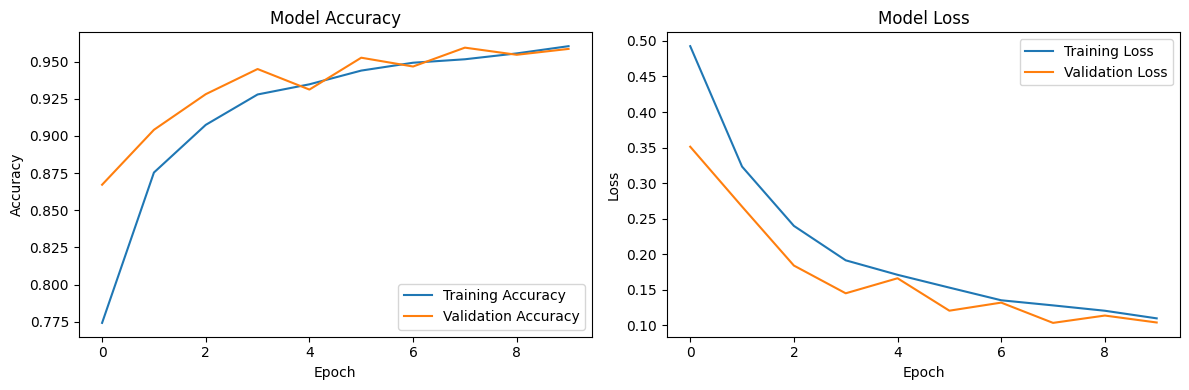

In [28]:

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Save the Model
Save the trained model for later use:

In [ ]:
model.save('pet_classifier_model.h5')
print("Model saved successfully!")


In [30]:
# Load the .h5 model
model = tf.keras.models.load_model('pet_classifier_model.h5')

# Convert to TFLite with TF Select ops enabled
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable TF Select ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops
]

# Optional: Enable optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the model
with open('pet_classifier_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model converted successfully!")

INFO:tensorflow:Assets written to: C:\Users\dimit\AppData\Local\Temp\tmpe3uqoti_\assets


INFO:tensorflow:Assets written to: C:\Users\dimit\AppData\Local\Temp\tmpe3uqoti_\assets


Model converted successfully!
